## Section 3: Procedural generation with few qubits

We will now introduce a method to generate terrain using few qubits. Specifically, few enough qubits to be easy to simulate. Though the techniques here could also be used on real quantum devices, we will focus on simulation here.

First we will introduce some additional details about how to describe qubits, in order to explain the underlying process behind the method.

### Some mathematical notation

The states $|0\rangle$ and $|1\rangle$ represent two completely disjoint states that a qubit can be in, since they represent completely opposite outcomes for a certain measurement type. Specifically, they are the states that represent certainty for an outcome of `0` and `1`, respectively, for a z measurement. We refer to these two states as the *z basis*.

We can also define the *x basis*, using states that are certain to output `0` and `1` for x measurements. The state that is certain to output `0` is typically referred to as $|+\rangle$, and that for `1` is $|-\rangle$.

In this notation, the $|$ and $\rangle$ are often confusing to newcomers. The job of these symbols is essentially just to remind us that we are describing a quantum state. This ensures that $|0\rangle$, for example, is not confused with the number $0$ or bit value `0`.

There are an infinite number of possible single qubit states, and obviously they do not all have their own unique symbol. Instead it is possible to express any state in terms of any basis. For example, here are $|+\rangle$ and $|-\rangle$ expressed in terms of $|0\rangle$ and $|1\rangle$, and vice-versa.

$$
|+\rangle \, = \, \frac{1}{\sqrt{2}}|0\rangle \, + \,  \frac{1}{\sqrt{2}}|1\rangle, \,\,\,\, |-\rangle \, = \, \frac{1}{\sqrt{2}}|0\rangle \, - \,  \frac{1}{\sqrt{2}}|1\rangle, \\
|0\rangle \, = \, \frac{1}{\sqrt{2}}|+\rangle \, + \,  \frac{1}{\sqrt{2}}|-\rangle, \,\,\,\, |1\rangle \, = \, \frac{1}{\sqrt{2}}|+\rangle \, - \,  \frac{1}{\sqrt{2}}|-\rangle
$$

In general, any single qubit state can be expressed in the for $c_0 |0\rangle \, + \,  c_1 |1\rangle$. Here $c_0$ and $c_1$ are complex numbers, referred to as the amplitudes for $|0\rangle$ and $|1\rangle$. They can be directly used to determine the probabilities for the outcomes of a z measurement: $|c_0|^2$ represents the probability of getting a `0`, and $|c_1|^2$ is the probability for a `1`. The amplitudes for other possible sets of basis states, and hence the probabilities for the corresponding measurement, can be found by reexpressing the state in that basis.

Now we know how to write down single qubit states, which are already familiar to us from the last section, we can move on to multiqubit states. This is basically done by replacing the single bit values with bit strings. For example, measuring two qubits could yeild one of the four outputs `00`, `01`, `10` and `11`. Any state of two qubits can be represented

$$
c_{00} |00\rangle + c_{01} |01\rangle + c_{10} |10\rangle + c_{11} |11\rangle.
$$

Here $|c_{00}|^2$ represents the probability of getting `00` from a z measurement of both qubits, and so on. The states can also be expressed in terms of a tensor product, such as $|01\rangle = |0\rangle\otimes |1\rangle$. For readers who are not familiar with this, in the context of this work it is simply a way of combining the states of two single qubits into one two qubit state, and it behaves in equations in the same way as multiplication.

The default initial state of two qubits is expressed $|00\rangle$, which simply implies that both are in state $|0\rangle$. Applying gates then transforms the state. For example, applying `ry` for an angle $\theta$ has the effect

$$
|0\rangle \rightarrow \cos \frac{\theta}{2} \, |0\rangle + \sin \frac{\theta}{2} |1\rangle, \,\,\,\, |1\rangle \rightarrow \cos \frac{\theta}{2} \, |1\rangle + \sin \frac{\theta}{2} |0\rangle
$$

If only done to one qubit of a two qubit state, the result would be

$$
|00\rangle = |0\rangle \otimes |0\rangle \rightarrow |0\rangle \otimes \left( \cos \frac{\theta}{2} \, |0\rangle + \sin \frac{\theta}{2} |1\rangle \right) = \cos \frac{\theta}{2} \, |00\rangle + \sin \frac{\theta}{2} |01\rangle
$$

Here it is the qubit on the right on which the gate was applied. By repeating the same process, we could similarly calculate the effect of further gates on this qubit, or gates on the other qubit.

For a more in-depth treatment of all these topics, consult the Qiskit textbook$^1$. However, what we have seen so far already covers the behaviour that will be used in this section: Single qubit rotations allow us to peturb an initial state. After a rotation for a small value of $\theta$ the state is mostly what it was initially (in this case $|00\rangle$). However, some amplitude has also been moved to neighbouring basis states (in this case $|01\rangle$). Here 'neighbouring' refers to the Hamming distance of the bit strings, and so two states are considered neighbouring if their bitstrings differ on only a single bit.

In this section we will introduce a method to encode height maps in quantum states. Using exactly the effect described above, we will then use single qubit rotations to peturb those heightmaps. The end result will be a method that this essentially a quantum version of one of the most rudimentary techniques in procedural generation: the box blur.

### Converting heightmaps to quantum states

In this section we are focussing on relatively small quantum processors of around 10 qubits. We will want to use them to generate maps with thousands of points. Clearly there is a difference of scale between the two. However, as we saw above, the state of $n$ qubits is described by a set of $2^n$ amplitudes: one for each possible output bit strings. We can therefore close the gap by making use of all these. Unfortunately, gaining access to all these numbers is not a trivial task. By the very fact that the number of them is exponential with the number of qubits, the complexity of calculating them is also exponential.

In the method that follows we will specifically look to access the probabilities for each of the $2^n$ possible output bit strings (for a z measurement of each qubit) rather than the amplitudes themselves. This can be done by repeating a circuit many times to sample from the output. Specificially, we will use `shots=4**n` samples. This exponential complexity is what limits the method to being used only on small processors.

To get started we will need the same tools as in the last section

In [1]:
from qiskit import QuantumCircuit, execute, Aer
from math import pi

import random

from tools import plot_height

as well as some basic tools for maths.

In [2]:
import numpy as np

Our first task is to find a mapping between the numbers that describe a heightmap (height values for each coordinate) and the numbers that describe a quantum state (amplitudes for each z basis bit string). The most important element of this is to define a mapping between the coordinates and the bit strings.

The ideal mapping for our purposes would be one that maps neighbouring coordinates to neighbouring bit strings. For example, if we map some $(x,y)$ to `0000` it would be ideal to have something like

* $(x+1,y) \, \rightarrow$ `1000`
* $(x-1,y) \, \rightarrow$ `0100`
* $(x,y+1) \, \rightarrow$ `0010`
* $(x,y-1) \, \rightarrow$ `0001`

Here the Manhattan distance between any two points is equal to the Hamming distance between the corresponding bit strings.

In general, this will not be a perfect mapping. We usually consider heightmaps based on 2D square lattices, whereas the structure formed by the Hamming distance between $n$-bit strings forms an $n$-dimensional hypercube. This will mean that there will always have to be non-neighbouring coordinates whose bit strings are neighbours.  However, we can ensure that neighbouring coordinates always have neighbouring bit strings.

The core of how we do this is defined in the following function, `make_line`. This creates a sequence of unique bit strings of at least a given `length`, such that each bit string in the list is a neighbour to those before and after.

In [3]:
def make_line ( length ):
    # determine the number of bits required for at least `length` bit strings
    n = int(np.ceil(np.log(length)/np.log(2)))
    # start with the basic list of bit values
    line = ['0','1']
    # each application of the following process double the length of the list,
    # and of the bit strings it contains
    for j in range(n-1):
        # this is done in each step by first appending a reverse-ordered version of the current list
        line = line + line[::-1]
        # then adding a '0' onto the end of all bit strings in the first half
        for j in range(int(len(line)/2)):
            line[j] += '0'
        # and a '1' onto the end of all bit strings in the second half
        for j in range(int(len(line)/2),int(len(line))):
            line[j] += '1'
    return line

For example, here is a list of length 8.

In [4]:
line = make_line(8)
print(line)

['000', '100', '110', '010', '011', '111', '101', '001']


With this, we can use `line[x]+line[y]` to define a unique string for each coordinate of an $8\times8$ grid. For example, for the point $(3,5)$ we can take the string at `line[3]` to serve as the $x=3$ coordinate, and the string `line[6]` to serve as $y=5$. These are the strings `010` and `111`, respectively. The string for the combined coordinates is then simply obtained by putting this together, giving us $(3,6)\,\rightarrow$ `010111`.

The following function, `make_grid` runs through all the coordinates of an `L`$\times$`L` grid, calculates the corresponding bit string, and then outputs all the results. This is done as a Python dictionary, with bit strings as keys and the corresponding coordinates as values.

In [5]:
def make_grid(L):
    
    line = make_line( L )
    
    grid = {}
    for x in range(L):
        for y in range(L):
            grid[ line[x]+line[y] ] = (x,y)
    
    return grid

For example, for an $8\times8$ grid, we find that the bit string `010111` corrsponds to exactly the set of coordinates that we saw above.

In [6]:
grid = make_grid(8)
grid['010111']

(3, 5)

Now we have figured out what to do with the coordinates in a heightmap, it is time to focus on the height values themselves. To do this, we will assume that each value $h$ exists in the range $0\leq h \leq 1$, and that the largest of all the heights is equal to exactly $1$. This assumption is without loss of generality, since any set of heights can be shifted and rescaled into this form.

We will define a quantum state for which the probability of a bit string $b$ is proportional to the height of the corresponding point ${\tt grid[ } b {\tt \\]}$,

$$
\frac{ p_{b'} }{ p_{b} } = \frac{ h_{ {\tt grid[ } b' {\tt \\]} } }{ h_{ {\tt grid[} b {\tt \\]} } }
$$

The reason why we cannot simply set $p_{b} = h_{ {\tt grid[} b {\tt \\]} }$ is because probabilities must always sum to 1. To acheive this we simply renormalize using 

$$
p_{b} = \frac{ h_{ {\tt grid[} b {\tt \\]} } }{ H }, \,\,\,\, H = \sum_b h_{ {\tt grid[} b {\tt \\]} }.
$$

Now we have the probabilities, we need corresponding amplitudes for the basis states. When we restrict to the case that these amplitudes are real numbers, they are related to the probability by the simple relation $c_b = \sqrt{p_b}$. The state we require to encode our heightmap is then

$$
\frac{1}{\sqrt{H}} \sum_b \sqrt{h_b} \, | b \rangle
$$

Now we can construct a function to convert create this state for any given heightmap. Specifically, we will convert the heightmap to a Qiskit `QuantumCircuit` object. This will contain a circuit to prepares the required state from the initial $|00\ldots00\rangle$ state. Fortunately, the construction of the required circuit can be done by the Qiskit function `initalize`. All it needs is for us to supply the required state. The whole process is implemented by the function `height2circuit`, below.

In [7]:
def height2circuit(height,grid):
    
    n = len( list(grid.keys())[0] )
        
    state = [0]*(2**n)
    
    H = 0
    for bitstring in grid:
        (x,y) = grid[bitstring]
        if (x,y) in height:
            h = height[x,y]
            state[ int(bitstring,2) ] = np.sqrt( h )
            H += h
        
    for j,amp in enumerate(state):
        state[ j ] = amp/np.sqrt(H)
                
    qc = QuantumCircuit(n,n)
    qc.initialize( state, qc.qregs )
        
    return qc

### Converting quantum states to heightmaps

The next job is to implement the opposite process: to turn a quantum circuit into an image. This is done by running the circuit for many samples, and using the number of samples that give each result to determine the probabilities. These probabilities are then rescaled such that the largest is equal to 1, in order to regain the original heightmap. This is done in the `circuit2height` function below.

In [8]:
def circuit2height(qc,grid,backend,shots=None,log=False):
    
    # get the number of qubits from the circuit
    n = qc.n_qubits
    
    # construct a circuit to perform z measurements
    meas = QuantumCircuit(n,n)
    for j in range(n):
        meas.measure(j,j)
        
    # if no shots value is supplied use 4**n by default (unless that is too small)
    if not shots:
        shots = max(4**n,8192)

    #run the circuit on the supplied backend
    counts = execute(qc+meas,backend,shots=shots).result().get_counts() 
    
    # determine max and min counts values, to use in rescaling
    if log: # log=True uses the log of counts values, instead of the values themselves
        min_h = np.log( 1/10 ) # fake small counts value for results that didn't appear
        max_h = np.log( max( counts.values() ) )
    else:
        min_h = 0
        max_h = max( counts.values() )   
    
    # loop over all bit strings in `counts`, and set the corresponding value to be
    # the height for the corresponding coordinate. Values are rescaled to ensure
    # that the biggest height is 1, and that no height is less than zero.
    height = {}
    for bitstring in counts:
        if bitstring in grid:
            if log: # log=True uses the log of counts values, instead of the values themselves
                height[ grid[bitstring] ] = ( np.log(counts[bitstring]) - min_h ) / (max_h-min_h)
            else:
                height[ grid[bitstring] ] = ( counts[bitstring] - min_h ) / (max_h-min_h)
    
    return height

In the above functions, it is assumed that heightmaps are expressed in the form of Python dictionaries, with coordinates as keys and the corresponding heights as values. Absent coordinates are assumed to correspond to a value of 0. Here is an example of such a height map.

In [9]:
height = {(2,6):1,(2,5):1,(5,6):1,(5,5):1,(3,1):1,(4,1):1,(2,1):1,(5,1):1,(1,2):1,(6,2):1,(7,7):0}

The function `plot_height` below takes such height maps and plots them. This is done as a countour plot, with the default choice of colours being one that reflects terrain.

With this we can plot the example heightmap. In this case, we will use a greyscale colour scheme.

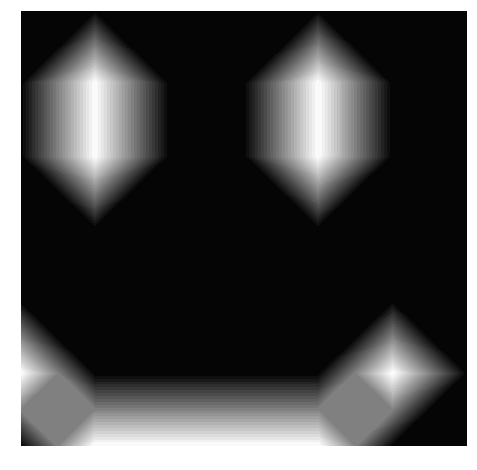

In [10]:
plot_height(height,color_map='gray')

We can now test the process that we have created so far by converting this heightmap into a quantum circuit, and then back into an image. In this test, we use the local simulator to run the circuit, which is invoked using `Aer.get_backend('qasm_simulator')`.

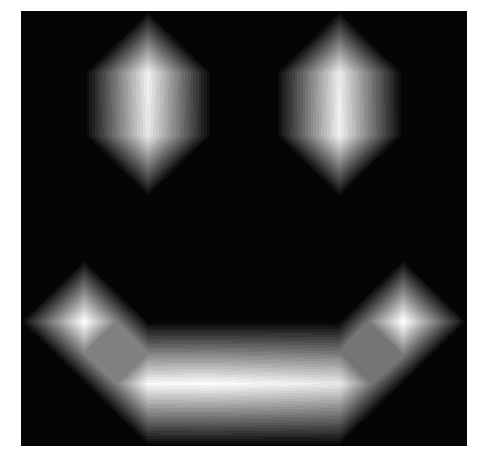

In [11]:
qc = height2circuit(height,grid)
new_height = circuit2height(qc,grid,Aer.get_backend('qasm_simulator'))
plot_height(new_height,L=8,color_map='gray')

Here we see that the image returns unscathed. For a more explicit comparison, we can look at the height values of the original and new heightmaps directly.

In [12]:
print("Coords  height new_height")
for pos in height:
    if height[pos]>0:
        print(pos,'',height[pos],'    ',new_height[pos])

Coords  height new_height
(2, 6)  1      0.9373549883990719
(2, 5)  1      0.9048723897911833
(5, 6)  1      0.9211136890951276
(5, 5)  1      0.9385150812064965
(3, 1)  1      0.9825986078886311
(4, 1)  1      0.9477958236658933
(2, 1)  1      0.968677494199536
(5, 1)  1      0.9071925754060325
(1, 2)  1      0.9953596287703016
(6, 2)  1      1.0


Here we see that the exact values of the original are slighly peturbed in the version that has gone through the quantum circuit. This is due to statistical noise when calculating probabilities using a finite number of samples. Increasing the number of `shots` could suppress the effect if required.

We can now manipulate the heighmap by applying gates to the quantum circuit. Though there are many possible choices we could make of what gates to apply, we will look at simply applying `ry` to all qubits by a given angle `theta`. 

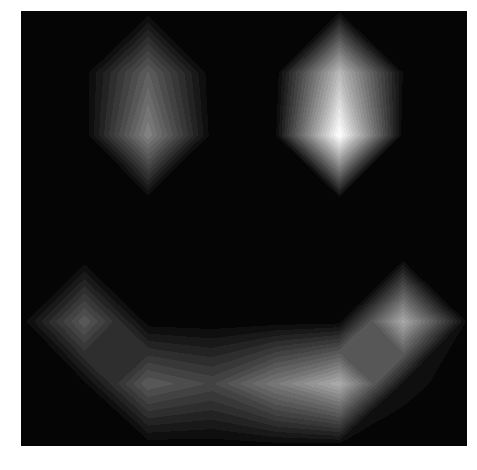

In [13]:
qc = height2circuit(height,grid)
qc.ry(pi/10,qc.qregs[0]) # shorthand for applying rx to all qubits in qc
new_height = circuit2height(qc,grid,Aer.get_backend('qasm_simulator'))
plot_height(new_height,L=8,color_map='gray')

From the above, we see that the effect of the given rotation angle is not large. This is partly because the effect induced by the rotation, which is to lead amplitude from each position to its neighbours, decays exponentially with distance for small `theta`. To boost the effect we will use the `log` keyword argument from the `circuit2height` function, which uses the logarithms of the probabilities as heights, rather than the probabilities themselves. This will help us get better results. As an example, here is the same process as that above, but with `log=True`.

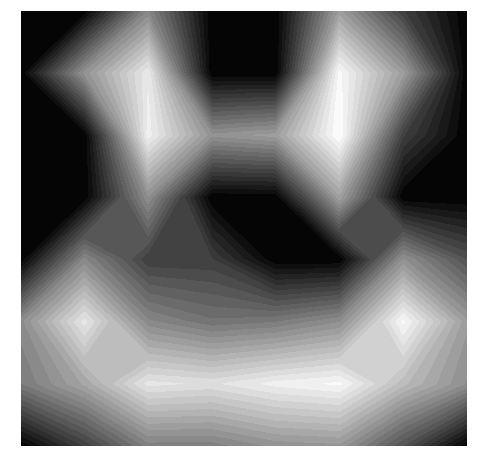

In [14]:
new_height = circuit2height(qc,grid,Aer.get_backend('qasm_simulator'),log=True)
plot_height(new_height,L=8,color_map='gray')

In this case we see the expected blur effect.

The effect of large angle rotations is not simply an extension of this blur effect. Instead, an interference effect is induced as the amplitudes from different sources begin to overlap. This can be seen most easily by starting with a checkerboard pattern for the heightmap.

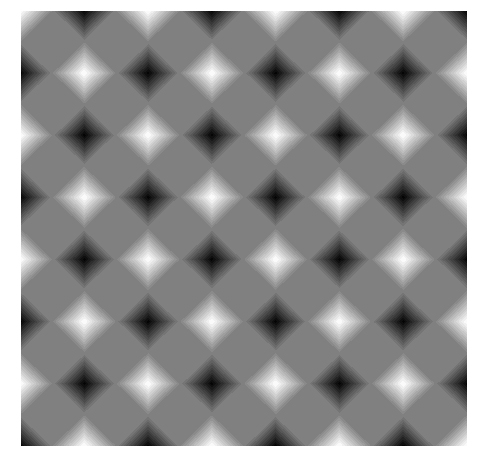

In [15]:
height = {}
for x in range(8):
    for y in range(8):
        height[x,y] = (x+y)%2
plot_height(height,L=8,color_map='gray')

The corresponding quantum state is an equally weighted superposition of all bit strings with even parity. It is known as the GHZ state$^2$, and is an example of a highly entangled state. In this case, for an $8x8$ grid, it is an entangled state of 6 qubits.

This state was chosen because of it's particular behaviour when `ry` rotations are applied. Even for small angle rotations, the effect is different than a simple blur. Instead, the interference effects cause the amplitude to become focussed in two particular points.

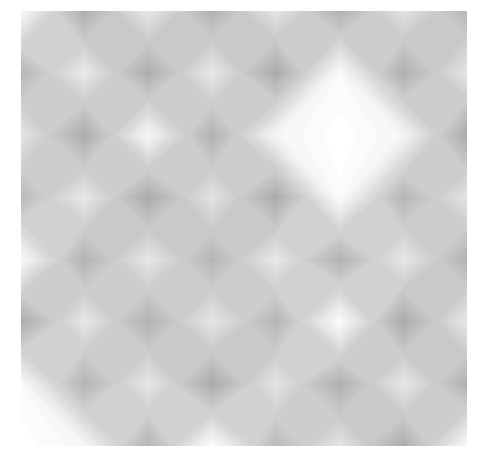

In [16]:
qc = height2circuit(height,grid)
qc.ry(pi/8,qc.qregs[0])
new_height = circuit2height(qc,grid,Aer.get_backend('qasm_simulator'),log=True)
plot_height(new_height,L=8,color_map='gray')

The effect peaks for the angle `pi/2`, which we should regard as a large angle in this context.

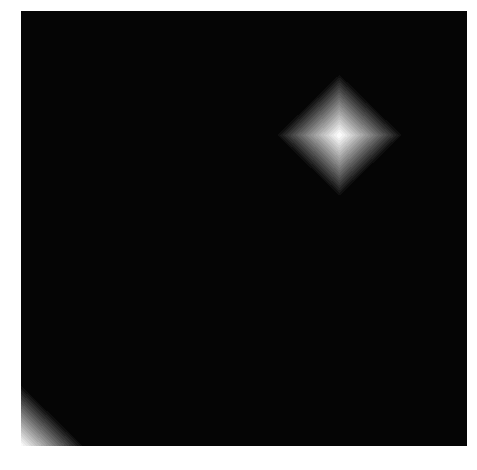

In [17]:
qc = height2circuit(height,grid)
qc.ry(pi/2,qc.qregs[0])
new_height = circuit2height(qc,grid,Aer.get_backend('qasm_simulator'),log=True)
plot_height(new_height,L=8,color_map='gray')

The underlying state here is

$$
\frac{1}{\sqrt{2}} \left( |000000\rangle + |111111\rangle \right).
$$

so all amplitude is concentrated at the corresponding two points.

Most heightmaps we consider will not be so extreme in their behaviour. However, they will always lead to quantum interference effects in some form. This allows us to generate interesting patterns, which we can then use in procedurally generated content.

For the rest of this section, we will apply the process to randomly generated seed images, created by the function `generate_seed` below.

In [18]:
def generate_seed(L,num=5):
    # generate a height map of `num` randomly chosen points, each with randomly chosen values
    seed = {}
    for _ in range(num):
        x = random.randint(0,L-1)
        y = random.randint(0,L-1)
        seed[x,y] = random.random()
    # set one to have a height of exactly 1
    seed[random.choice(list(seed.keys()))] = 1
        
    return seed

Here is an example for `L=16`.

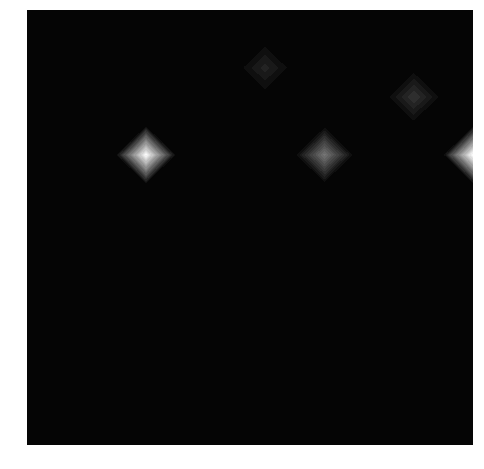

In [19]:
L = 16
grid = make_grid(L)
seed = generate_seed(L)
plot_height(seed,L,color_map='gray')

We will apply $\pi/4$ `ry` rotations to this in order to induce quantum interefence effects and obtain a resulting pattern. We will refer to such patterns as *quantum tartan*.

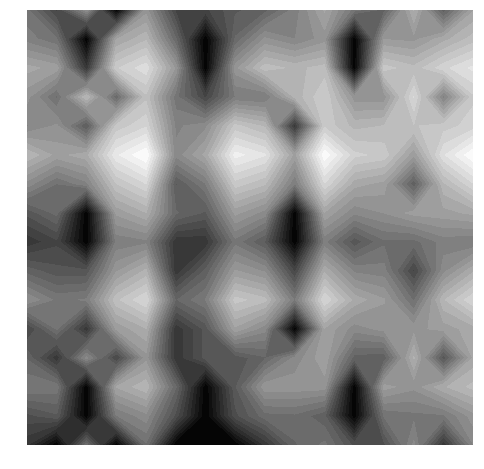

In [20]:
qc = height2circuit(seed,grid)
qc.ry(pi/4,qc.qregs[0])

tartan = circuit2height(qc,grid,Aer.get_backend('qasm_simulator'),log=True)
plot_height(tartan,color_map='gray')

An obvious way to obtain more examples of quantum tartan is to apply the process for different seed images. However, we can also generate new and unique results without needing to run the quantum circuit again. Instead, we can use the fact that the `grid` used above is not the only mapping of bitstrings to coordinates that serves our needs. In fact, we can create alternative versions by simply shuffling each bit string in the same way. This will yield another mapping of bitstrings to coordinates, but preserve the fact that neighbouring coordinates have neighbouring bit strings.

The function `shuffle_height` below peforms this shuffling for a given `grid`. It then produces a new heightmap, for which each position is moved to the point corresponding to the shuffled version of its bit string. The result is new quantum tartan produced from the same results from the same quantum job.

In [21]:
def shuffle_height (height,grid):
    
    # determine the number of qubits
    n = int( np.log(len(grid))/np.log(2) )
    
    # randomly choose a way to shuffle the bit values in the string
    shuffle = [j for j in range(n)]
    random.shuffle(shuffle)
    
    # for each bit string, determine and record the pair of positions
    # * `pos`: the position correspoding to the bit string in the given `grid`
    # * `new_pos`: the position corresponding to the shuffled version of the bit string
    remap = {}
    for bitstring in grid:
        
        shuffledstring = ''.join([bitstring[j] for j in shuffle])

        pos = grid[bitstring]
        new_pos = grid[shuffledstring]
        
        remap[pos] = new_pos
        
    # create and return `new_height`, in which each point is moved from `pos` to `new_pos`
    new_height = {}
    for pos in height:
        new_height[remap[pos]] = height[pos]
        
    return new_height

As an example, here is a shuffled versio of the above tartan.

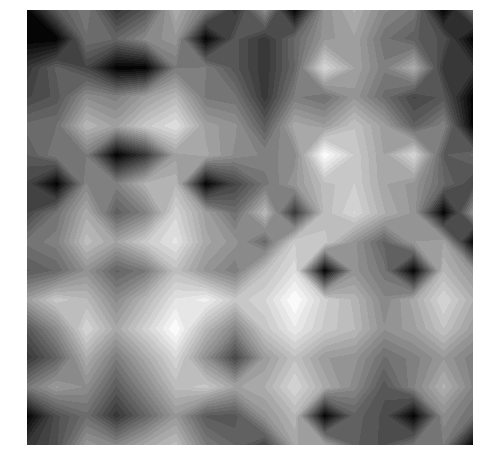

In [22]:
plot_height(shuffle_height(tartan,grid),L,color_map='gray')

### Creating a quantum island

The size of these heightmaps is $16\times 16$. We could increase this number, but at the cost of runtime for the quantum process (or simulation thereof). In order to create a large map, we will need to use another technique.

To be concrete, we will aim to create an improved version of the island from the last section.

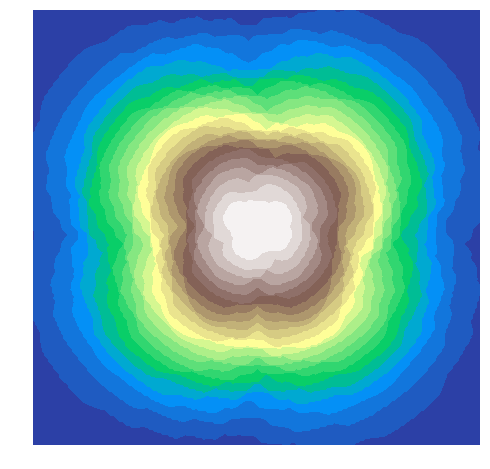

In [27]:
from island import island

size = max(max(island))+1
        
plot_height(island)

It is still a bit too smooth to be interesting for a player to explore within a game. To solve this problem, we will overlay it with quantum tartan. The following code generates a set of tartans by shuffling the one generated above.

In [28]:
tartans = [ shuffle_height(tartan,grid) for _ in range(int(size/L)) ]

The overlaying procedure is done by moving selecting successive $L\times L$ patches of the island, moving by a distance of $L/2$ between each. For each patch, the height of the island at each point is combined with that of corresponding point within the tartan. Finally, the result is renormalized such that the maximum value is 1.

The process is described most effectively by the code itself.

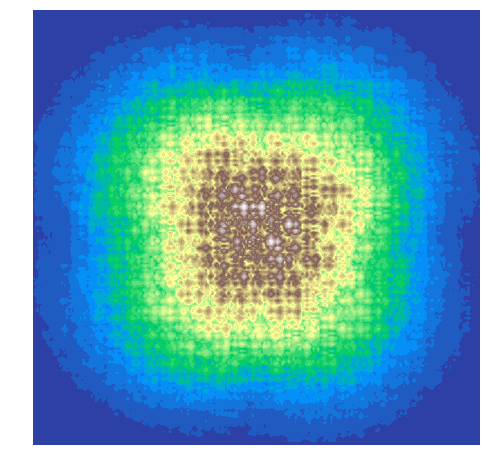

In [29]:
quantum_island = {}
for x0 in range(0,size+int(L/2),int(L/2)):
    for y0 in range(0,size+int(L/2),int(L/2)):
        tartan = random.choice(tartans) # choose a random tartan from the list
        for (x,y) in tartan:
            xx = x-int(L/2)+x0
            yy = y-int(L/2)+y0
            if (xx,yy) in island:
                quantum_island[xx,yy] = (1+tartan[x,y])*island[xx,yy]
                
# renormalize
max_height = max(quantum_island.values())
for (x,y) in quantum_island:
    quantum_island[x,y] = quantum_island[x,y]/max_height
    
# plot the result
plot_height(quantum_island,size)

The result is better than the original island, though still not entirely realistic. It serves as the starting point for generating interesting and realtistic terrain.

A more advanced use of these techniques is found in the blog post on which this section was based$^3$. One method used there is to overlay the tartans randomly, rather than successively overlaying in a strict pattern. Code to implement such a process, as well as an example of it in action, can be found below.

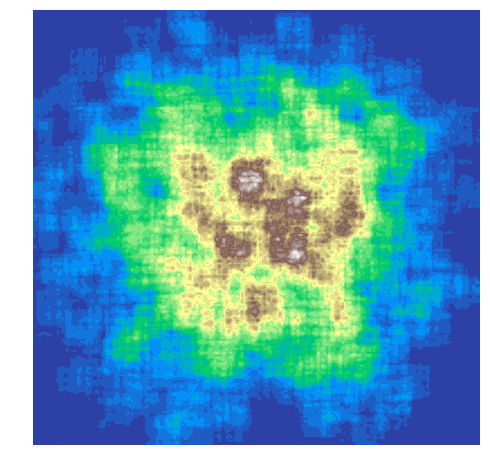

In [30]:
quantum_island = {}
for _ in range(int(10*size**2/L**2)):
    chosen = False
    while not chosen:
        x0 = random.randint(0,size-1)
        y0 = random.randint(0,size-1)
        chosen = (random.random()<island[x0,y0])
    tartan = random.choice(tartans)
    for (x,y) in tartan:
        xx = x-int(L/2)+x0
        yy = y-int(L/2)+y0
        if (xx,yy) in quantum_island:
            quantum_island[xx,yy] += tartan[x,y]
        else:
            quantum_island[xx,yy] = tartan[x,y]
                
max_height = max(quantum_island.values())

for (x,y) in quantum_island:
    quantum_island[x,y] = quantum_island[x,y]/max_height
    
plot_height(quantum_island,size)

## References

1. ["Learn Quantum Computing using Qiskit", Qiskit Community (2019)](https://community.qiskit.org/textbook/)
2. ["Going Beyond Bell's Theorem", D. Greenberger, et al (1989)](https://arxiv.org/abs/0712.0921)
3. ["Creating infinite worlds with quantum computing", J. Wootton (2019)](https://medium.com/qiskit/creating-infinite-worlds-with-quantum-computing-5e998e6d21c2)
4. [The Ædwen Brooch, British Museum collection online](https://www.britishmuseum.org/research/collection_online/collection_object_details/collection_image_gallery.aspx?partid=1&assetid=752049001&objectid=64612)

## Towards a combined approach

A set of tartans, as produced here, will be used in the combined terrain generation procedure of [Section 5](5_A_Combined_Approach.ipynb). This procedure was developed during the PROCJAM 2019 game jam, which had a theme of 'Heritage'. Inspired by this, the seed images will be 8x8 pixel representations of the pseudo-runes from the Ædwen Brooch$^4$. This is an Anglo-Saxon artefact, decorated with runes that are probably only there to convey a sense of Viking mystery.

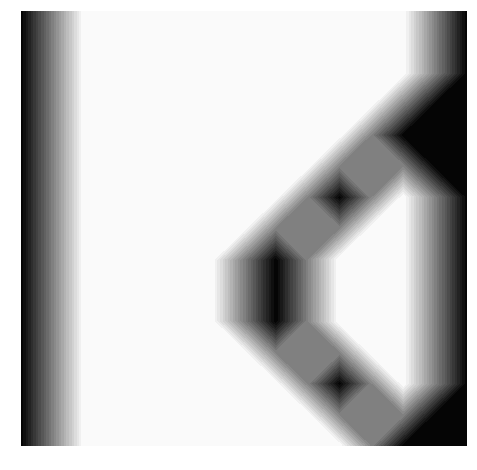

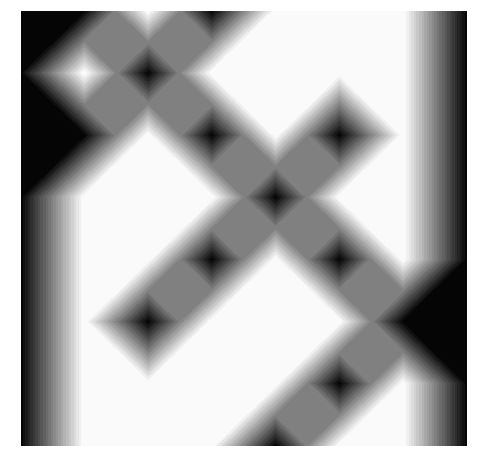

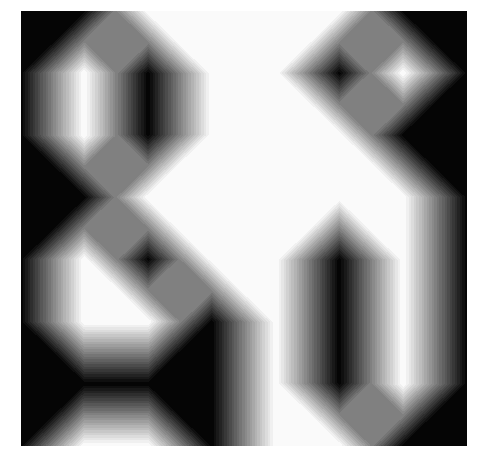

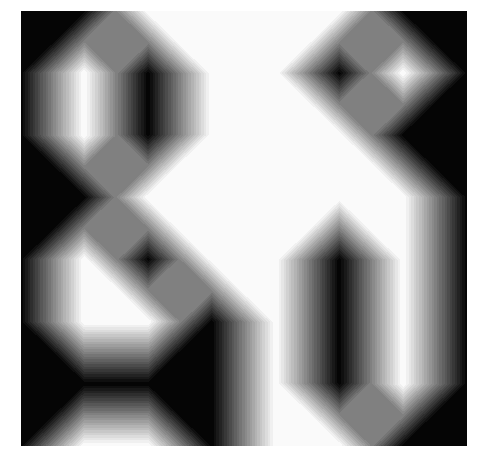

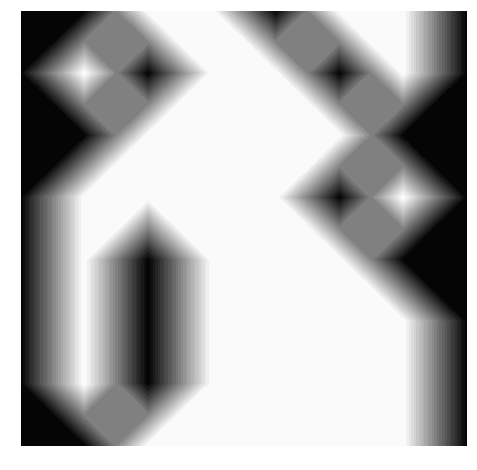

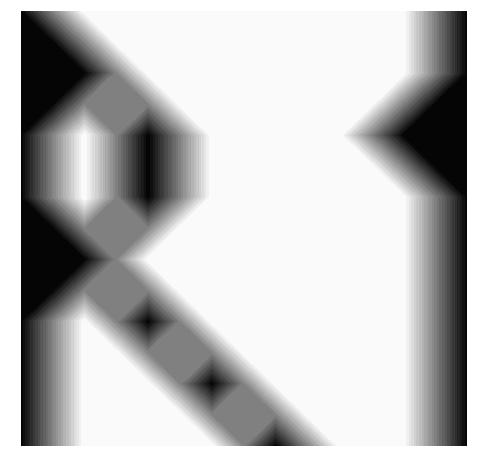

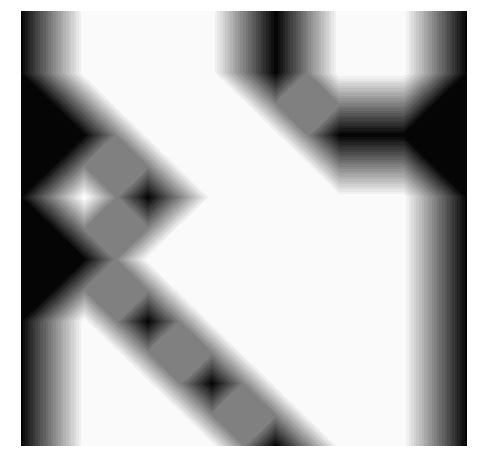

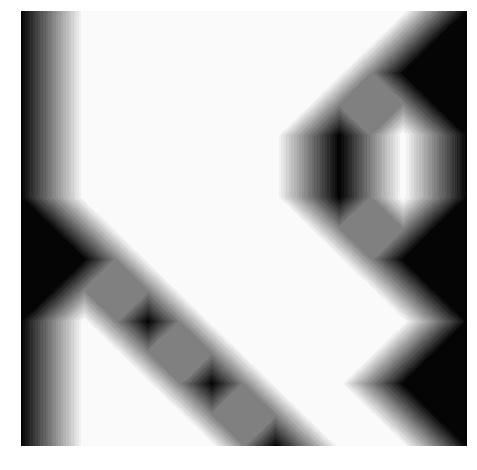

In [31]:
from runes import runes

for rune in runes:
    plot_height(rune,color_map='gray')

They will do the same thing in the content that we will procedurally generate, though with the addition of a quantum twist. Fourteen quantum runes will be created, two from each of Ædwen's runes. One of these will be lightly perturbed with an angle of $\pi/32$. The other will get a more significant perturbation of $\pi/8$.

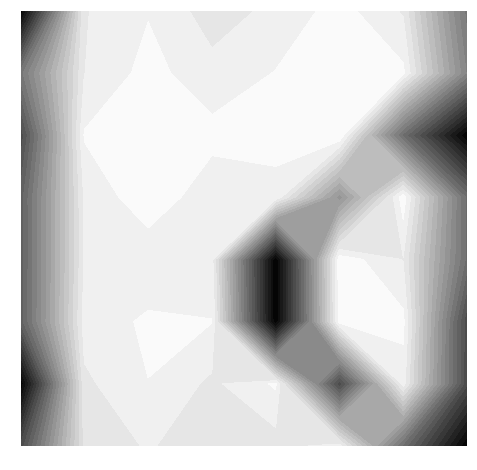

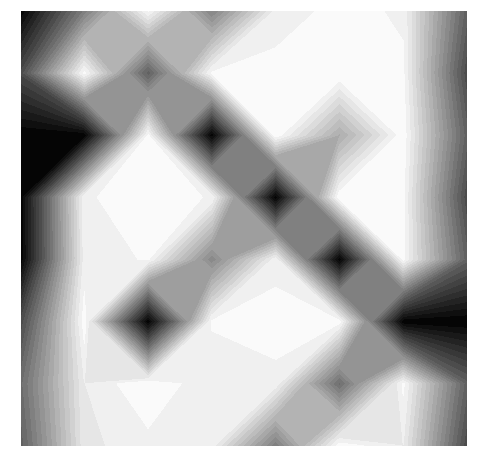

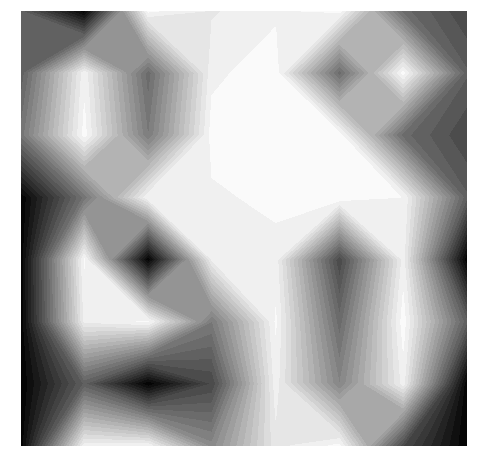

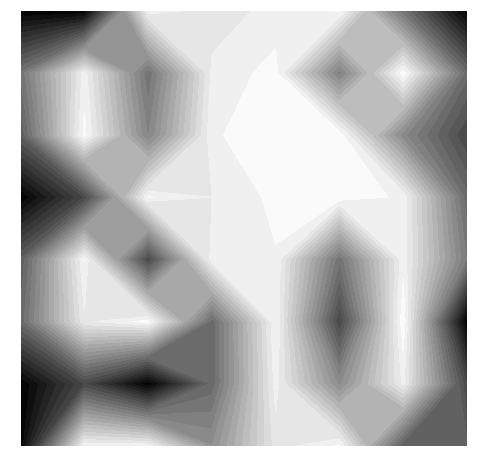

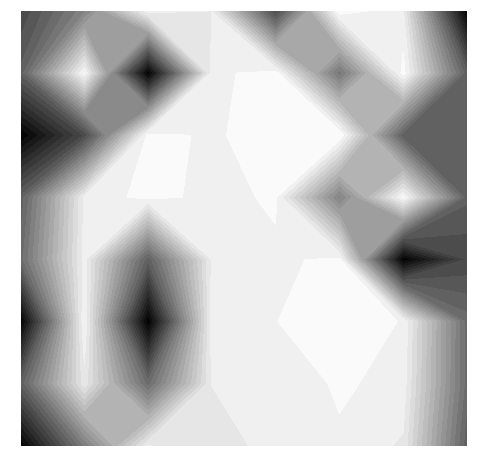

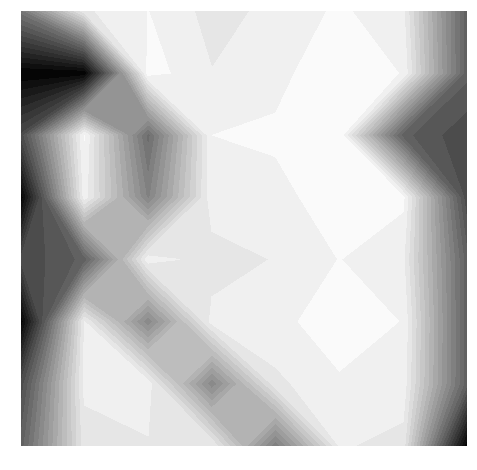

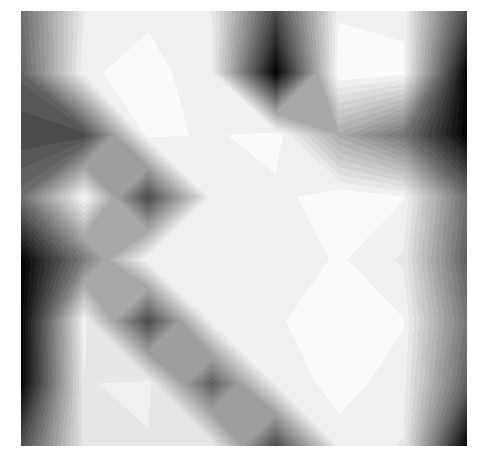

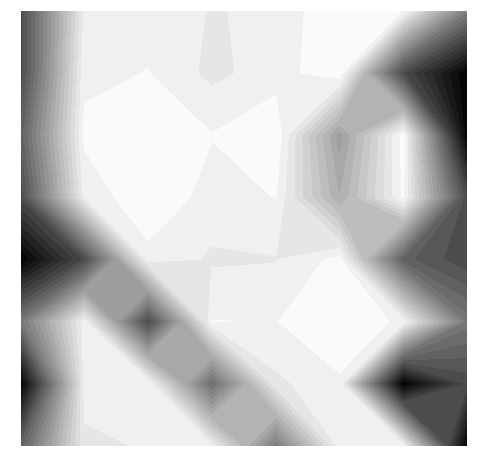

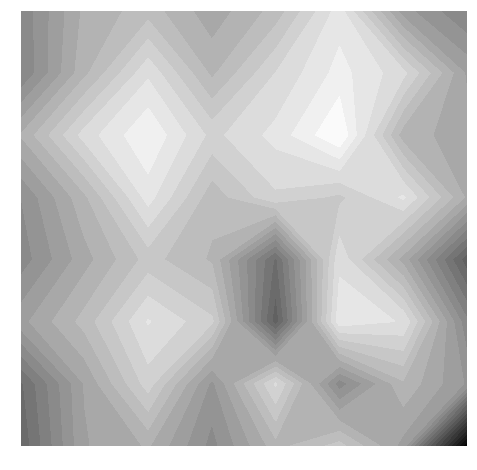

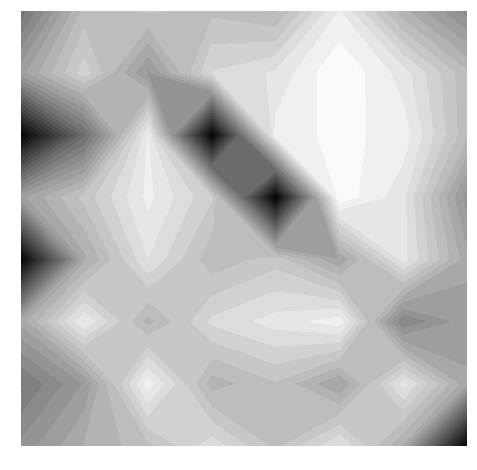

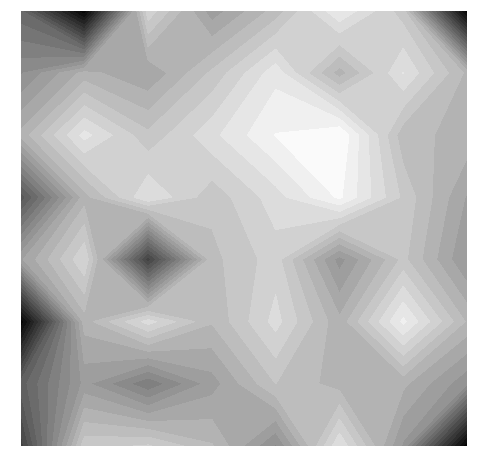

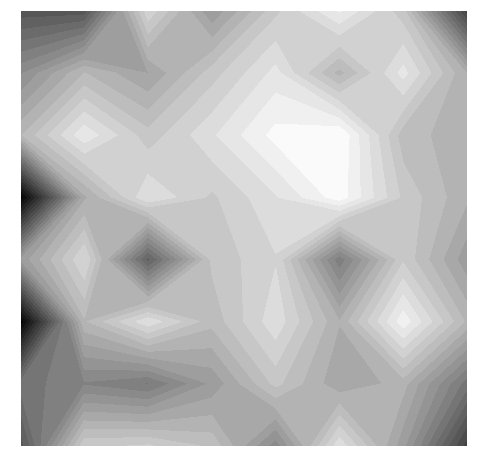

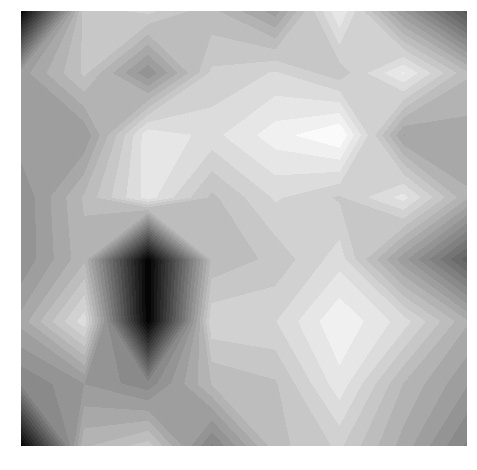

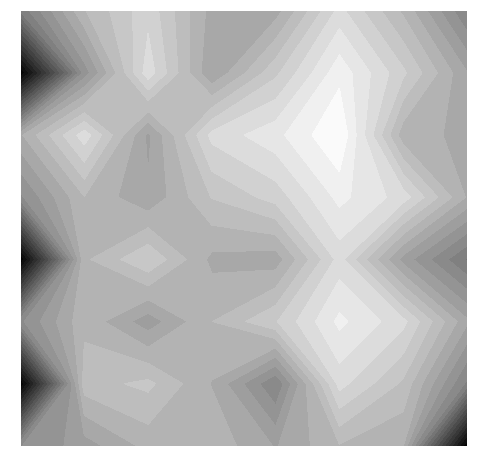

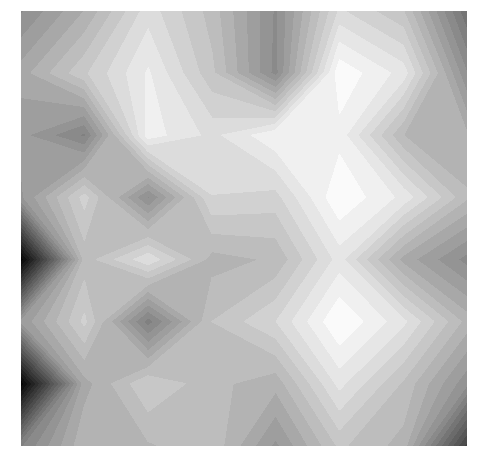

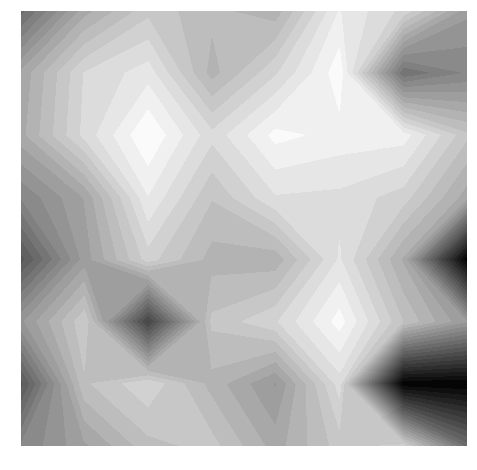

In [32]:
from runes import runes

tartans = []

for theta in [pi/32,pi/8]:
    for rune in runes:
        
        L = max(max(rune))+1
        grid = make_grid(L)
            
        qc = height2circuit(rune,grid)
        qc.ry(theta,qc.qregs[0])
                
        tartan = circuit2height(qc,grid,Aer.get_backend('qasm_simulator'),log=True)
                        
        plot_height(tartan,L=8,color_map='gray')
        
        tartans.append( tartan )
        
with open('tartans.py', 'w') as file:
    file.write('tartans='+str(tartans))